In [7]:
%reload_ext autoreload
%autoreload 2

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from src import const
from src.env.env_basic import WaterLeakEnv


Path.cwd()

PosixPath('/Users/adamzh0u/315_RL/cege_test')

## From data to feature 

In [58]:
df = pd.read_csv(const.PATH_DATA/'simulation'/'Data_water_demand_with_leaks_41_1000.txt')

In [59]:
env = WaterLeakEnv(data = df)
# env._next_observation()
# obs, reward, terminated, info = env.step(1)
# reward

## eps_greedy


record dumped to data/train/eps_greedy_record.npy


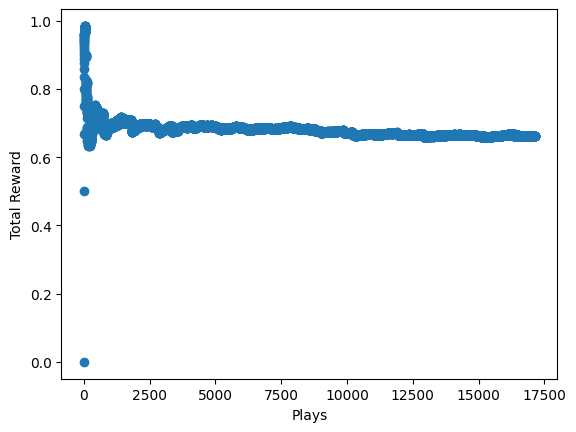

In [47]:
from src.agents.agent_epsgreedy import AgentGreedy

env = WaterLeakEnv(data = df)
agent = AgentGreedy(env)

ls_rewards = agent.run(train=True, eps=0.1)

fig, ax=plt.subplots(1,1)
ax.set_xlabel("Plays")
ax.set_ylabel("Total Reward")
total_reward = np.cumsum(ls_rewards)
mean_reward = total_reward/np.arange(1,len(total_reward)+1)
ax.scatter(range(len(mean_reward)), mean_reward)

# dqn

In [102]:
import numpy as np
import torch
import torch.nn as nn

env = WaterLeakEnv(data = df)

window_size = 10
N, D_in, H, D_out=1, window_size, 100, 2
# N是批大小，D_in是输入维度，H是隐藏维度，D_out是输出维度

model=torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.ReLU(),
)

class WaterPipeRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(WaterPipeRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out


model = WaterPipeRNN(input_size=1, hidden_size=64, output_size=2, num_layers=2)

loss_fn=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.01)

epochs=5000
learning_rate=1e-2
cur_state=torch.Tensor(obs[-10:]) # float tensor

In [79]:
def softmax(av, tau=1.12):
    softm=np.exp(av / tau) / np.sum( np.exp(av / tau) )
    return softm

In [63]:
def one_hot(action, N=2, val=1):
    one_hot_vec=np.zeros(N)
    one_hot_vec[action]=val
    return one_hot_vec

In [ ]:
# 负奖励转换为正奖励是一种常见的技术，特别是在使用算法如 DQN 时，因为某些损失函数或算法可能对负值处理不好。
# 通常 Q-learning 算法（包括 DQN）直接选择 Q 值最大的动作。然而，你提到要使用 softmax 将动作转化成向量

mean reward: [-0.001 -0.002 -0.003  0.002  0.001]


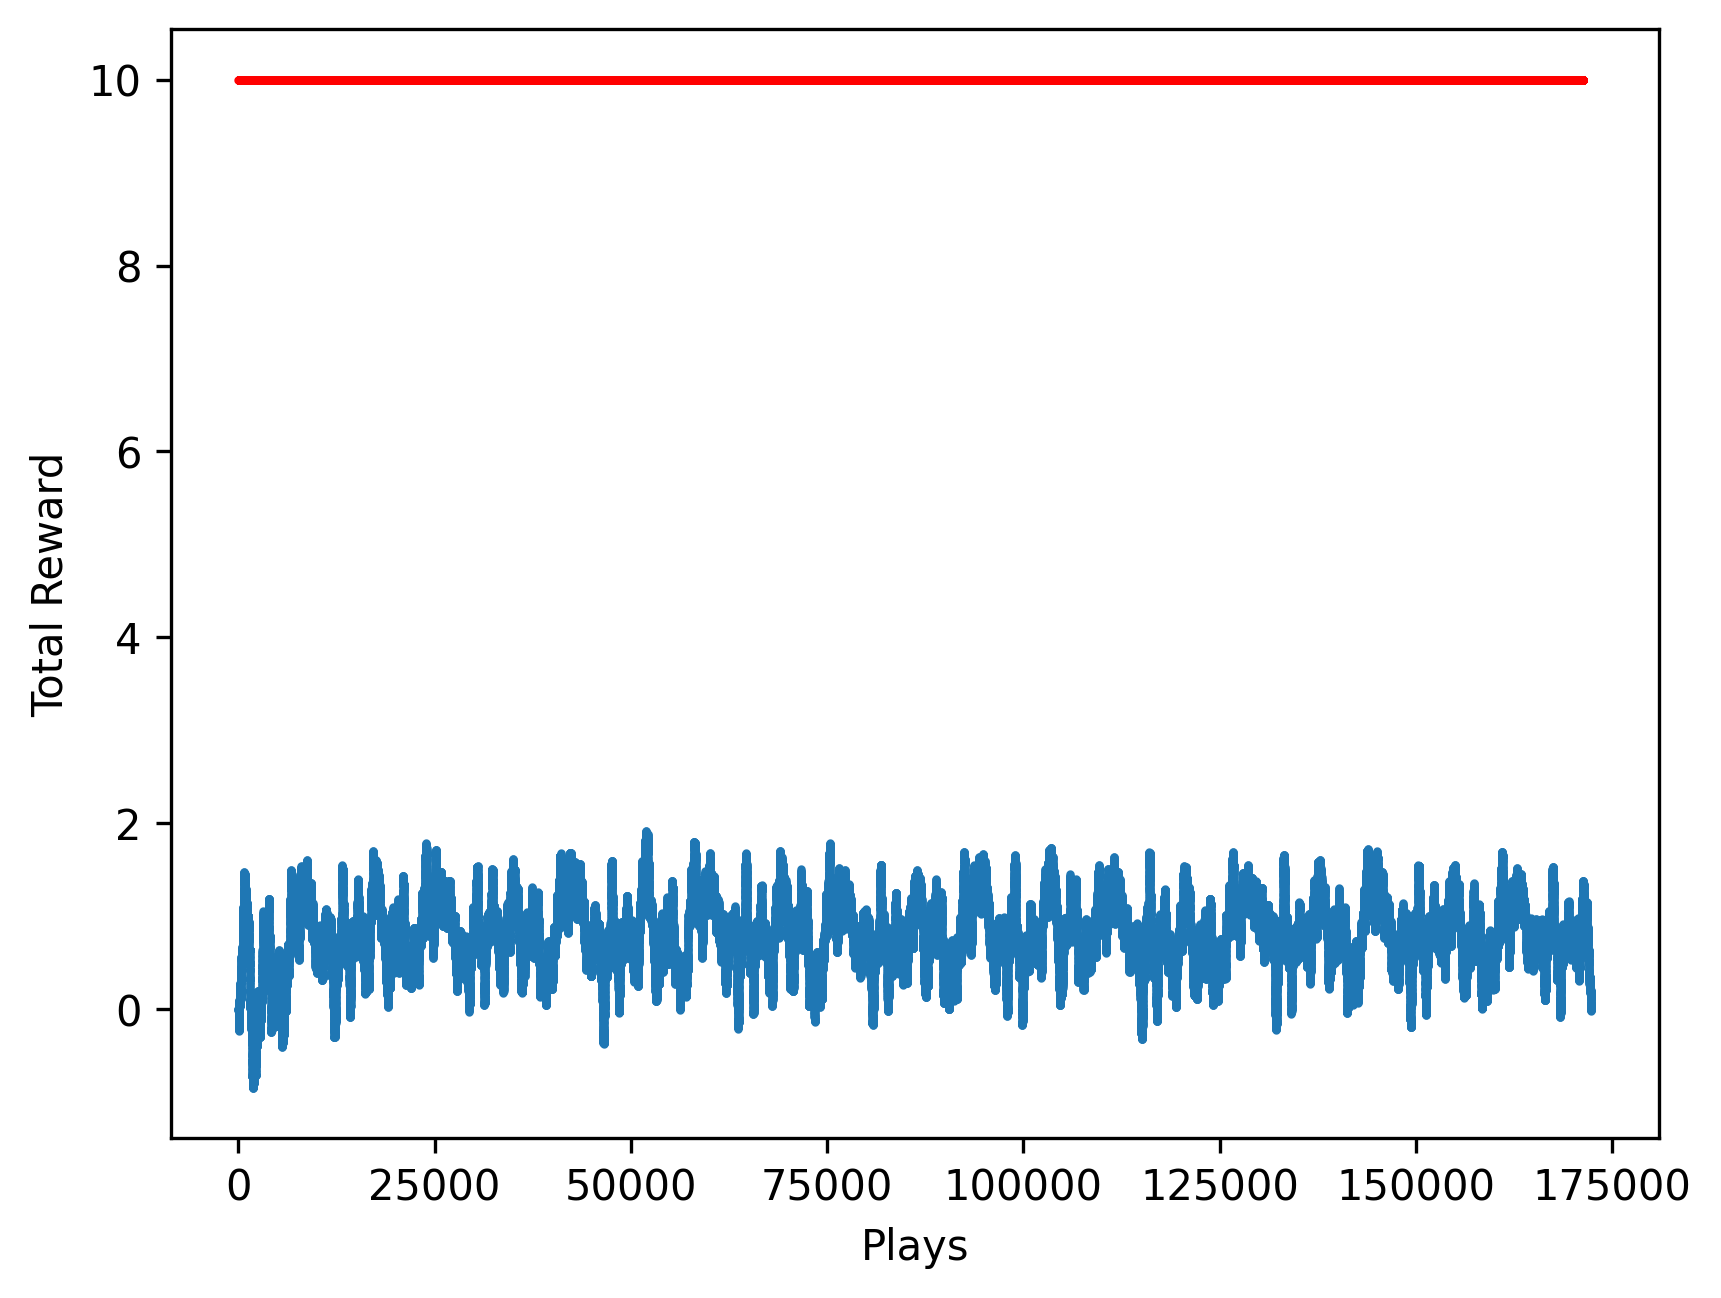

In [98]:
def plot_reward(ls_rewards):
    fig, ax=plt.subplots(1,1,dpi=300)
    # mean reward of each 100 plays
    mw_mean = np.convolve(ls_rewards,np.ones(1000,dtype=int))/1000
    ax.scatter(range(len(mw_mean)), mw_mean,s=1)

    # plot index if  >2 in ls_rewards
    ls_rewards = np.array(ls_rewards)
    idx = np.where(ls_rewards>2)
    ax.scatter(idx, ls_rewards[idx], color='red',s=1)
    ax.set_xlabel("Plays")
    ax.set_ylabel("Total Reward")
    print(f'mean reward: {mw_mean[-5:]}')

plot_reward(ls_rewards)

In [81]:
from tqdm import tqdm

ls_rewards=[0]

reward_shift = 11
use_softmax = True
epochs = 10

for epoch in tqdm(range(epochs)):

    obs = env.reset()
    terminated=False
    while not terminated:
        # run network to get Q values of each action
        pred_q_value=model(cur_state) 
        if use_softmax:
            av_softmax=softmax(pred_q_value.data.numpy(), tau=2.0)
            av_softmax /=av_softmax.sum()
            action=np.random.choice([0,1], p=av_softmax)
        else:
            action=np.argmax(pred_q_value.data.numpy())

        # take action and get reward
        obs, reward, terminated, info = env.step(action)
        dqn_reward=reward + reward_shift  # shift to make q values positive

        # 
        target_q_value=pred_q_value.data.numpy().copy()
        target_q_value[action] = dqn_reward
        target_q_value=torch.Tensor(target_q_value)

        # backpropagation
        loss=loss_fn(pred_q_value, target_q_value)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record rewards
        ls_rewards.append(reward)
        
        # next state
        cur_state=torch.Tensor(obs[-10:])


100%|██████████| 10/10 [00:34<00:00,  3.43s/it]


## lstm dqn

In [108]:
env.action_space.n

2

In [ ]:
import wandb

In [103]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random

# 定义RNN-DQN模型
class RNN_DQN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, action_size):
        super(RNN_DQN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, action_size)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))

# 定义DQN代理
class DQNAgent:
    def __init__(self, state_size, action_size, hidden_size, num_layers, gamma=0.99, lr=0.001, batch_size=64, memory_size=10000):
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gamma = gamma
        self.lr = lr
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.model = RNN_DQN(state_size, hidden_size, num_layers, action_size)
        self.target_model = RNN_DQN(state_size, hidden_size, num_layers, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.update_target_model()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, hidden, epsilon=0.1):
        if np.random.rand() <= epsilon:
            return random.randrange(self.action_size), hidden
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values, hidden = self.model(state, hidden)
        return np.argmax(q_values.cpu().detach().numpy()), hidden

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            target = self.model(state, self.model.init_hidden(1))[0].detach()
            if done:
                target[0][action] = reward
            else:
                t = self.target_model(next_state, self.model.init_hidden(1))[0].detach()
                target[0][action] = reward + self.gamma * torch.max(t)
            output = self.model(state, self.model.init_hidden(1))[0]
            loss = self.criterion(output, target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def load(self, name):
        self.model.load_state_dict(torch.load(name))

    def save(self, name):
        torch.save(self.model.state_dict(), name)

# 训练DQN代理
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size, hidden_size=64, num_layers=2)

episodes = 1000
for e in range(episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    hidden = agent.model.init_hidden(1)
    for time in range(500):
        action, hidden = agent.act(state, hidden)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            agent.update_target_model()
            print(f"episode: {e}/{episodes}, score: {time}, e: {epsilon:.2}")
            break
        agent.replay()

# 保存模型
agent.save("rnn_dqn_model.pth")


/Users/adamzh0u/anaconda3/envs/py310_dl/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


ValueError: cannot reshape array of size 2 into shape (1,4)

In [104]:
state

(array([-0.02077138,  0.00405103,  0.01810145, -0.00872065], dtype=float32),
 {})